In [571]:
import yaml
import pandas as pd
import seaborn as sns
from datetime import datetime as dt

In [572]:
path_to_beancounter = '/Applications/World of Warcraft/_classic_/WTF/Account/BLUEM/SavedVariables/BeanCounter.lua'
#path_to_beancounter = 'BeanCounter.lua'

In [573]:
# Reads the beancounter database and converts all items:code into a dict
with open(path_to_beancounter, 'r') as f:
    beans = f.readlines()
    
start_db = [i for i, x in enumerate(beans) if 'BeanCounterDBNames' in x][0] + 1
end_db = [i for i, x in enumerate(beans) if 'BeanCounterAccountDB' in x][0] - 1

def parse_item(x):
    return x.split(';')[1].split('"')[0].replace('"', '')

def parse_code(x):
    return x.split('"')[1].split(':')[0]

full_items = dict([(parse_item(x), parse_code(x)) for x in beans[start_db: end_db]])

In [574]:
# Load my inventory list, ensure keys are typed up correctly
# Gets relevant list of items
with open(f'inventory.yaml', 'r') as f:
    inventory = yaml.load(f, Loader=yaml.FullLoader)
    
for sku in inventory:
    assert sku in full_items    
    
items = dict([(value, key) for key, value in full_items.items() if key in inventory])  

pots = [x for i, x in items.items() if 'Potion' in x or 'Elixir' in x]

print(f"I'm in the market for {len(items)} items, and selling {len(pots)} potions and Elixirs")

I'm in the market for 55 items, and selling 21 potions and Elixirs


In [575]:
# Find the relevant section of the file to do with actual auctions
sale_start = [i for i, x in enumerate(beans) if 'Amazoni' in x][0] + 1
sale_end = [i for i, x in enumerate(beans) if 'BeanCounterDBSettings' in x][0] - 6

records = beans[sale_start: sale_end]

In [576]:
# Pattern matching logic for records
item_pattern_a = '\t\t\t\t["'
item_pattern_b = '"] = {\n'

detail_pattern_a = '\t\t\t\t\t\t"'
detail_pattern_b = '", -- [1]\n'

def pattern_fit(line, pattern, left=True):
    """
    Given a line of text, and a left/right pattern, return True or False for matching    
    """
    if len(line) <= len(pattern):
        return False
    elif left:
        return line[:len(pattern)] == pattern
    else:
        return line[-len(pattern):] == pattern
    
    
def pattern_extract(line, patterns=[]):
    return line[len(patterns[0]):len(line)-len(patterns[1])]


def get_auction_type(record):
    #if 'postedAuctions' in record: return 'postedAuctions'
    #if 'failedAuctions' in record: return 'failedAuctions'
    if 'completedBidsBuyouts' in record: return 'completedBidsBuyouts'
    if 'completedAuctions' in record: return 'completedAuctions'

In [577]:
auction_type = None
item_id = None
detail = None
data = []

for record in records:
    
    if get_auction_type(record):
        auction_type = get_auction_type(record)
        
    if pattern_fit(record, item_pattern_a) and pattern_fit(record, item_pattern_b, left=False):
        item_id = pattern_extract(record, [item_pattern_a, item_pattern_b])
        
    if '\t\t\t\t\t\t"' in record and '", -- [' in record:
        detail = record.split('\t\t\t\t\t\t"')[1].split('", -- [')[0]
    else:
        detail = None
        
    if auction_type and item_id and detail:
        row = [auction_type, item_id] + detail.split(';')
        data.append(row)

In [578]:
df = pd.DataFrame(data)

In [579]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,completedBidsBuyouts,12006,1,,636,,81859,73673,,1578161035,,A
1,completedBidsBuyouts,6562,1,,300,,80000,70000,,1578161040,,A
2,completedBidsBuyouts,6371,1,,,,5576,5438,,1582929914,,A
3,completedBidsBuyouts,6371,1,,,,5576,5438,,1582929914,,A
4,completedBidsBuyouts,6371,1,,,,5576,5438,,1582929914,,A
...,...,...,...,...,...,...,...,...,...,...,...,...
9373,completedAuctions,3824,1,,,,,30000,Gordonian,1578351263,,A
9374,completedAuctions,3824,1,,,,,30000,Wispers,1578351261,,A
9375,completedAuctions,3824,1,,,,,30000,Gordonian,1578351259,,A
9376,completedAuctions,12808,1,,,,,11500,Carbene,1578516974,,A


In [580]:
# Create dataframe and filter to only our items we care about
df = pd.DataFrame(data)

df = df[df[1].isin(items)]
df[1] = df[1].replace(items)

df = df.drop_duplicates()
df = df.drop([3,4,5,6,10,11], axis=1)

df[0] = df[0].replace({'completedBidsBuyouts': 'Bought', 'completedAuctions': 'Sold'})

df.columns = ['Action', 'Item', 'Qty', 'Price', 'Player', 'Timestamp']

df['Qty'] = df['Qty'].astype(int)
df['Price'] = round(df['Price'].astype(int) / 10000, 4)

# Make purchases negative
df.loc[df[df['Action']=='Bought'].index, 'Price'] = - df.loc[df[df['Action']=='Bought'].index, 'Price']

df['PricePer'] = round(df['Price'] / df['Qty'], 4)



In [581]:
new_df = df.copy()

In [582]:
df = new_df

In [583]:
df = df.drop_duplicates().dropna()

In [584]:

# Set index to timestamp
df['Timestamp'] = df['Timestamp'].apply(lambda x: dt.fromtimestamp(int(x)))
df = df.set_index('Timestamp').sort_index()

sold = df[df['Action']=='Sold']
bought = df[df['Action']=='Bought']

In [585]:
df

,Action,Item,Qty,Price,Player,PricePer
Timestamp,,,,,,
2019-11-17 23:01:22,Bought,Major Healing Potion,2,-3.3600,Culstire,-1.6800
2019-11-17 23:01:30,Bought,Major Healing Potion,1,-1.6999,Azureaegis,-1.6999
2019-11-17 23:01:33,Bought,Major Healing Potion,1,-1.6999,Azureaegis,-1.6999
2019-11-17 23:01:35,Bought,Major Healing Potion,1,-1.6999,Azureaegis,-1.6999
2019-11-17 23:01:38,Bought,Major Healing Potion,1,-1.6999,Azureaegis,-1.6999
...,...,...,...,...,...,...
2020-03-10 19:57:25,Bought,Elixir of Greater Intellect,5,-3.5140,,-0.7028
2020-03-10 19:57:55,Bought,Elixir of Superior Defense,1,-1.6097,,-1.6097
2020-03-10 19:57:55,Bought,Elixir of Superior Defense,1,-1.7578,,-1.7578


## Analysis

### Sales activity

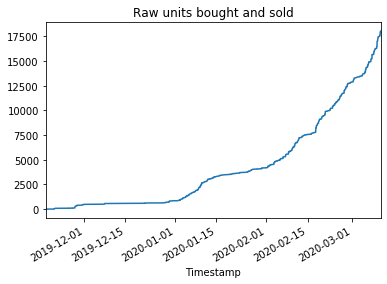

In [586]:
df['Qty'].cumsum().plot(title='Raw units bought and sold')

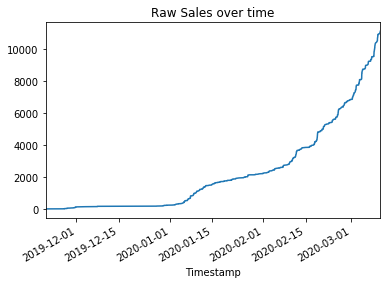

In [587]:
sold['Price'].cumsum().plot(title='Raw Sales over time')

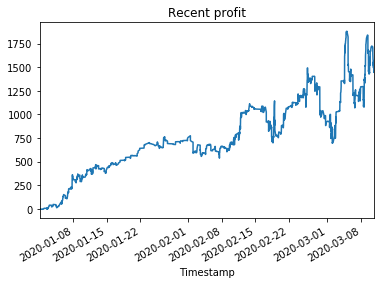

In [588]:
df.loc['2020-01-01':]['Price'].cumsum().plot(title='Recent profit')

In [589]:
# Gold per week based on since year start
df.loc['2020-01-01':]['Price'].cumsum()[-1] / ((df.index.max() - pd.to_datetime('2020-01-01')).days / 7)

151.3169202898543

In [590]:
# Gold per week based on since start alchy hording
df.loc['2020-02-04':]['Price'].cumsum()[-1] / ((df.index.max() - pd.to_datetime('2020-02-04')).days / 7)

179.3519599999998

### Profit breakdown

In [591]:
df

,Action,Item,Qty,Price,Player,PricePer
Timestamp,,,,,,
2019-11-17 23:01:22,Bought,Major Healing Potion,2,-3.3600,Culstire,-1.6800
2019-11-17 23:01:30,Bought,Major Healing Potion,1,-1.6999,Azureaegis,-1.6999
2019-11-17 23:01:33,Bought,Major Healing Potion,1,-1.6999,Azureaegis,-1.6999
2019-11-17 23:01:35,Bought,Major Healing Potion,1,-1.6999,Azureaegis,-1.6999
2019-11-17 23:01:38,Bought,Major Healing Potion,1,-1.6999,Azureaegis,-1.6999
...,...,...,...,...,...,...
2020-03-10 19:57:25,Bought,Elixir of Greater Intellect,5,-3.5140,,-0.7028
2020-03-10 19:57:55,Bought,Elixir of Superior Defense,1,-1.6097,,-1.6097
2020-03-10 19:57:55,Bought,Elixir of Superior Defense,1,-1.7578,,-1.7578


In [592]:
bought_qty = bought.groupby('Item').sum()['Qty']
bought_qty.name = 'B_Qty'

bought_price = bought.groupby('Item').mean()['PricePer']
bought_price.name = 'B_Price'

bought_total_sales = bought.groupby('Item').sum()['Price']
bought_total_sales.name = 'B_Sales'


sold_qty = sold.groupby('Item').sum()['Qty']
sold_qty.name = 'S_Qty'

sold_price = sold.groupby('Item').mean()['PricePer']
sold_price.name = 'S_Price'

sold_total_sales = sold.groupby('Item').sum()['Price']
sold_total_sales.name = 'S_Sales'


sales = pd.concat([bought_qty, bought_price, bought_total_sales, sold_qty, sold_price, sold_total_sales], 
                  axis=1, sort=True)

sales['Volume'] = sales['B_Qty'] + sales['S_Qty']

sales['Profit%'] = ((sales['S_Price'] / - sales['B_Price']) - 1) * 100 

sales = sales.fillna(0)

sales['Gross_Profit'] = (sales['S_Qty'] * sales['S_Price']) + (sales['B_Qty'] * sales['B_Price'])

sales['True_Profit'] = (sales['S_Sales'] + sales['B_Sales'])


sales['Weighted_Price'] = ((sales['S_Qty'] * sales['S_Price']) + (
                            sales['B_Qty'] * -sales['B_Price'])
                          ) / (sales['S_Qty'] + sales['B_Qty'])

sales = sales.round(2)


In [593]:
pot_sales = sales.loc[pots].sort_values('S_Qty', ascending=False)
pot_sales

,B_Qty,B_Price,B_Sales,S_Qty,S_Price,S_Sales,Volume,Profit%,Gross_Profit,True_Profit,Weighted_Price
Fire Protection Potion,189.0,-2.16,-437.61,960.0,2.09,2080.20,1149.0,-2.93,1602.78,1642.60,2.10
Mighty Rage Potion,13.0,-1.26,-15.63,367.0,1.04,379.42,380.0,-17.31,366.51,363.79,1.05
Elixir of Giants,37.0,-0.79,-29.43,277.0,0.94,256.07,314.0,17.80,229.81,226.64,0.92
Elixir of the Mongoose,77.0,-4.02,-315.79,251.0,5.42,1376.93,328.0,34.81,1050.87,1061.14,5.09
Elixir of Greater Agility,5.0,-1.04,-4.74,234.0,0.88,202.18,239.0,-15.68,200.16,197.45,0.88
Greater Arcane Protection Potion,39.0,-1.43,-56.30,161.0,1.21,196.86,200.0,-15.25,139.63,140.56,1.26
Elixir of Superior Defense,17.0,-1.67,-28.83,126.0,1.14,145.03,143.0,-32.11,114.74,116.20,1.20
Greater Shadow Protection Potion,20.0,-7.83,-157.52,109.0,7.48,822.11,129.0,-4.44,658.58,664.59,7.53
Greater Stoneshield Potion,18.0,-1.44,-25.89,103.0,1.17,113.77,121.0,-18.45,94.92,87.89,1.21
Arcane Elixir,3.0,-0.91,-2.74,81.0,0.94,81.13,84.0,3.33,73.70,78.39,0.94


In [594]:
sales.loc['UNKNOWN'] = 0

In [595]:
with open(f'recipes.yaml', 'r') as f:
    recipes = yaml.load(f, Loader=yaml.FullLoader)
    
potion_costs = {}
for key in recipes:
    recipe = recipes[key]
    cost = 0

    for ingredient in recipe:
        
        #last_10_buys = bought[bought['Item']==ingredient].tail(16)['PricePer'].mean()
        cost += sales.loc[ingredient, 'B_Price'] * recipe[ingredient]
    
    potion_costs[key] = cost

In [596]:
pot_sales['Mat_Cost'] = pot_sales.index
pot_sales['Mat_Cost'] = pot_sales['Mat_Cost'].apply(lambda x: potion_costs[x] if x in potion_costs else 0)

In [597]:
pot_sales['Profit Per Sale'] = pot_sales['S_Price'] + pot_sales['Mat_Cost']

In [598]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string


In [599]:
scat = pot_sales.iloc[1:][["Profit Per Sale", "S_Qty"]]
scat = scat[(scat['Profit Per Sale']>0.1) & (scat['S_Qty']>20)]

# most profitable items

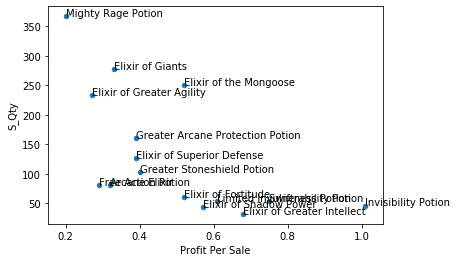

In [600]:
fig, ax = plt.subplots()
scat.plot("Profit Per Sale", "S_Qty", kind='scatter', ax=ax)

for k, v in scat.iterrows():
    ax.annotate(k, v)

In [601]:
Gromsblood x 4
Sungrass x 2 (+ sell)
Plaguebloom x 2
Mountain Silversage x 2
Goldthorn x 1 (+ sell)
Dreamfoil x 1
Arcane dust x 1

SyntaxError: invalid syntax (<ipython-input-601-12d82da54770>, line 1)

### Top players

In [ ]:
# These people have bought the most golds worth of goods from me
top_purchasers = sold.groupby('Player').sum()['Price']
top_purchasers.sort_values(ascending=False).head(20)

In [ ]:
# I have bought the most golds worth of goods from these players
top_vendors = bought.groupby('Player').sum()['Price']
top_vendors.sort_values(ascending=False).head(20)

### Pricing over time

In [ ]:
def show_price_history(name):

    b_test = -bought[bought['Item']==name]['PricePer']
    b_test.name = 'Bought'

    s_test = sold[sold['Item']==name]['PricePer']
    s_test.name = 'Sold'
    
    b_test = pd.DataFrame(b_test.loc[s_test.index.min():])

    joined = pd.merge(b_test, s_test, how='outer', left_index=True, right_index=True)
    joined = joined.interpolate()
    joined.plot(title=name)

In [ ]:
show_price_history('Elixir of the Mongoose')

In [ ]:
show_price_history('Mighty Rage Potion')

In [ ]:
show_price_history('Arcane Crystal')

In [ ]:
def get_action(row):
    """ Given an inventory size and stated preference, produces a Buy and Sell recommendations
    """
    if row['Inventory'] == 1 and row['Min']!=0:
        return ('Orange', 'No Sell')
    elif row['Inventory'] < 5 or row['Inventory'] < row['Ideal'] * 0.25:
        return ('Orange', 'Red')
    elif row['Inventory'] < row['Ideal'] * 0.75:
        return ('Yellow', 'Red')
    elif row['Inventory'] < row['Ideal'] * 1.25:
        return ('Green', 'Orange')
    elif row['Inventory'] < row['Max']:
        return ('Blue', 'Yellow')
    else:
        return ('No Buy', 'Green')

### Stocktake and Auction Actions

Set the thresholds according to market price
* Blue <80%
* Green 80-96%
* Yellow 96-104%
* Orange 104-120%
* Red 120%+

In [ ]:
inventory_df = pd.DataFrame.from_dict(inventory).T
stocktake = sales[['Weighted_Price']].join(inventory_df)
stocktake_value = (stocktake['Weighted_Price'] * stocktake['Inventory']).sort_values(ascending=False)
print(f"I have {round(stocktake_value.sum(),2)} gold locked in inventory")

In [ ]:
for ind, row in stocktake.iterrows():
    action = get_action(row)
    stocktake.loc[ind, 'Buy if'] = action[0]
    stocktake.loc[ind, 'Sell if'] = action[1]    
    
stocktake

In [ ]:
stocktake.to_csv('stocktake.csv')

## Shopping list (for rebalancing)

In [ ]:
shopping_df = stocktake.loc[pots]['Ideal'] - stocktake.loc[pots]['Inventory']
shopping_dict = shopping_df[shopping_df>0].to_dict()

In [ ]:
with open(f'recipes.yaml', 'r') as f:
    recipes = yaml.load(f, Loader=yaml.FullLoader)

shopping_total = {}
for key in shopping_dict:
    reagents = recipes[key]
    for r in reagents:
        if r != 'UNKNOWN':
            shopping_total[r] = reagents[r] * shopping_dict[key]        

In [ ]:
shopping_total

In [ ]:
stocktake['Requested'] = stocktake.index
stocktake['Requested'] = stocktake['Requested'].apply(lambda x: shopping_total[x] if x in shopping_total else 0)

In [ ]:
stocktake['Purchase'] = stocktake[['Ideal', 'Inventory']].max(axis=1) - stocktake['Inventory'] + stocktake['Requested']

In [ ]:
stocktake